<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Изучение-моделей" data-toc-modified-id="Изучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение моделей</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Цель исследования:
- Построить модель, прогнозирующую уйдёт клиент из банка в ближайшее время или нет
- Значение F1-меры должно быть больше 0.59

Этапы работы:
- Подготовка данных
- Исследование задачи
- Борьба с дисбалансом
- Тестирование модели

## Подготовка данных

Импортируем нужные нам библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

Датасет находится по пути: `/datasets/Churn.csv`, считаем его в переменную `data`, далее будем над ней работать

изучим первые 5 строк

In [2]:
#data = pd.read_csv('/datasets/Churn.csv')
data = pd.read_csv('Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Описание данных:

**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

Поссмотрим, какие типы данных у столбцов нашего датафрейма

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


С типами данных все хорошо

Видим, что мы имеем 5 численных столбцов и 5 категориальных

численные:
- CreditScore
- Age
- Tenure
- Balance
- EstimatedSalary

категориальные:
- Geography
- Gender
- NumOfProducts
- **HasCrCard**
- **IsActiveMember**

из них не всем нужно создавать дамми-признаки, столбцы `HasCrCard` и `IsActiveMember` хранят только нули и единицы, оставим их без изменений

и один целевой признак: `Exited`

Занесем их в списки для дальнейшей обработки

In [4]:
nums = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cats = ['Geography', 'Gender', 'NumOfProducts']

Изучим пропуски

In [5]:
pd.isnull(data).sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Пропуски есть только в столбце `Tenure`

In [6]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

Значения разнятся от 0 до 10, большинство значений около 7

Столбец Tenure хранит в себе информацию о том сколько лет человек является клиентом банка, эти данные нельзя получить из других столбцов, поэтому логичнее всего будет заполнить их медианным значением всех значений

In [7]:
#data['Tenure'].fillna(data['Tenure'].median(), inplace=True)
from random import uniform
data['Tenure'].fillna(uniform(0, 10), inplace=True)

In [8]:
pd.isnull(data).sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Вывод**

В данных было немного пропусков, их удалось заполнить

In [9]:
import sys
!{sys.executable} -m pip install pandas_profiling sweetviz

from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_widgets()

                                             |          | [  0%]   00:00 -> (? left)


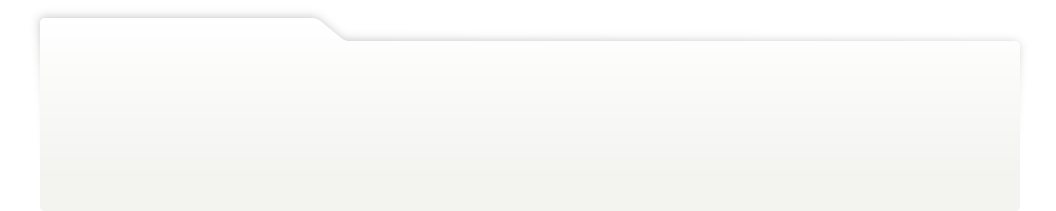
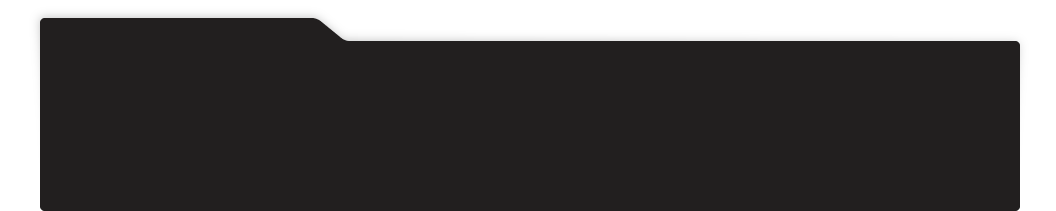
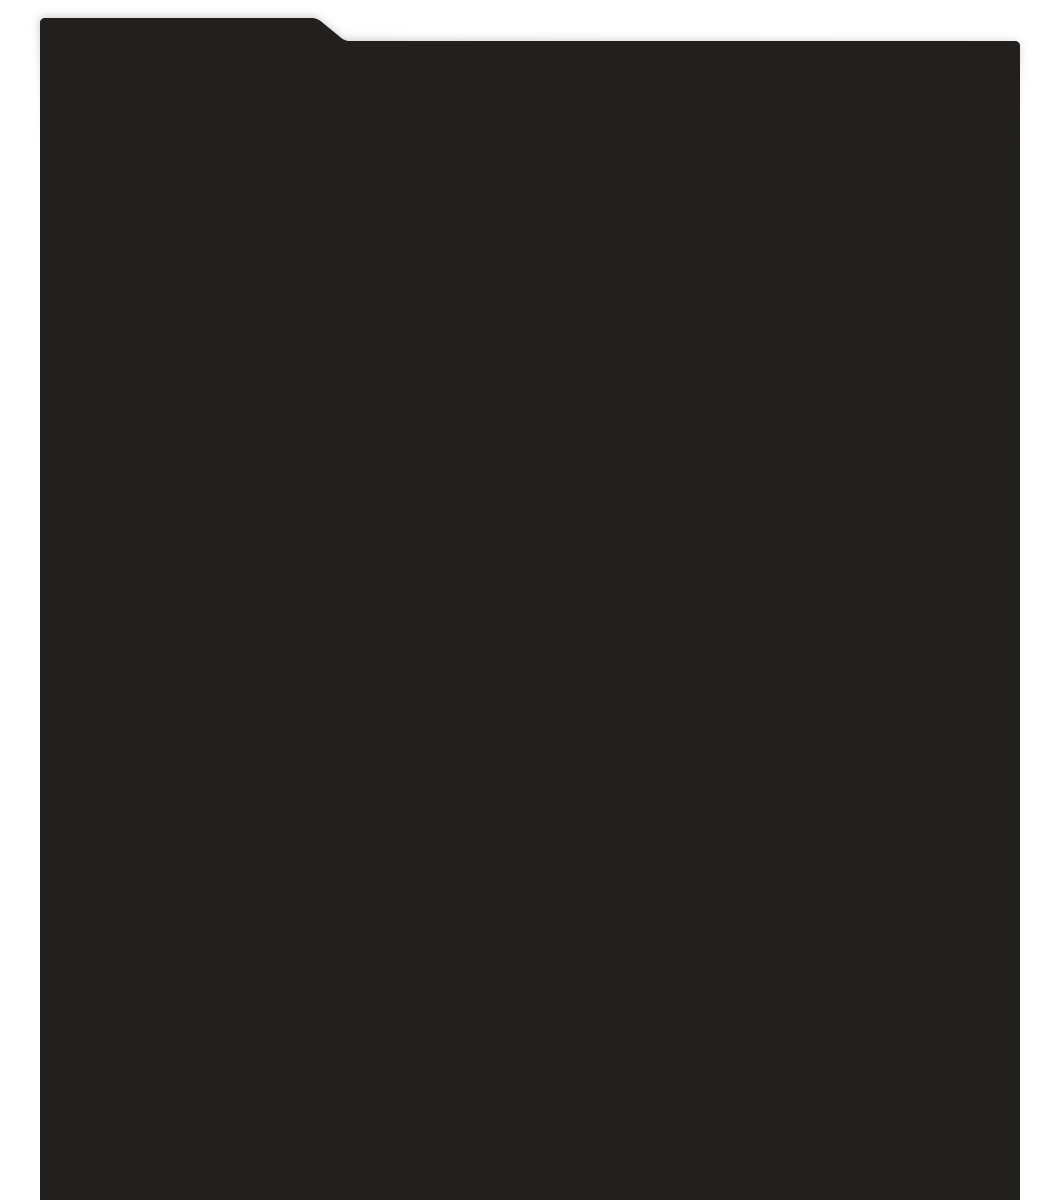
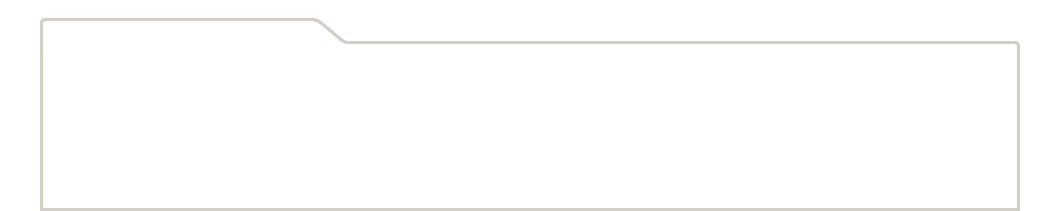
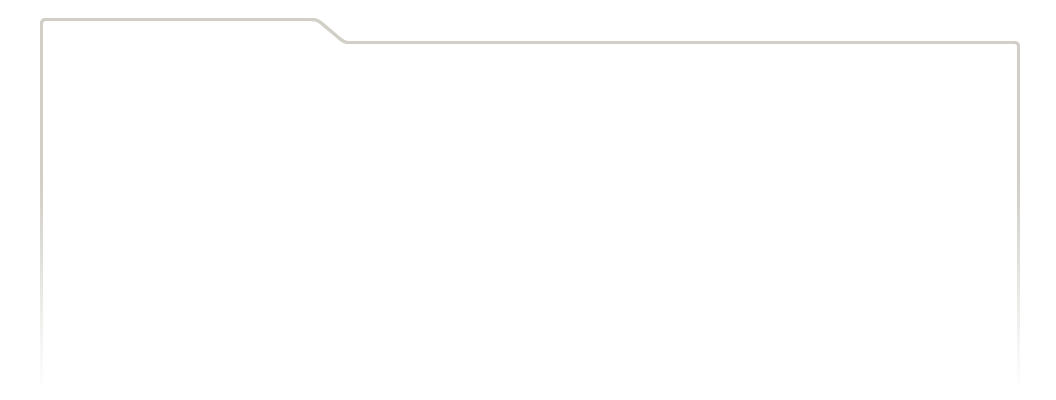
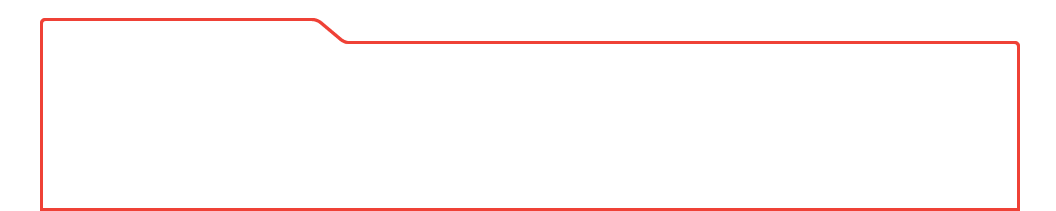
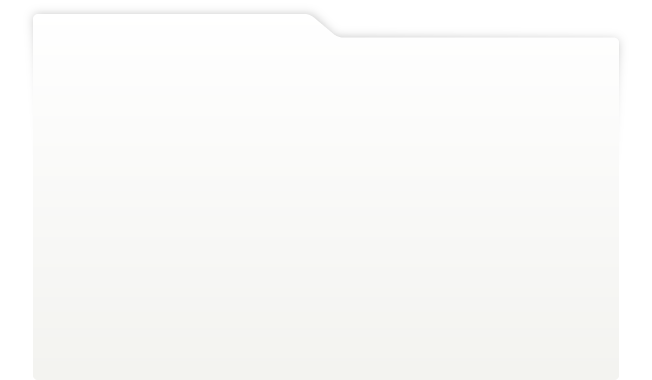
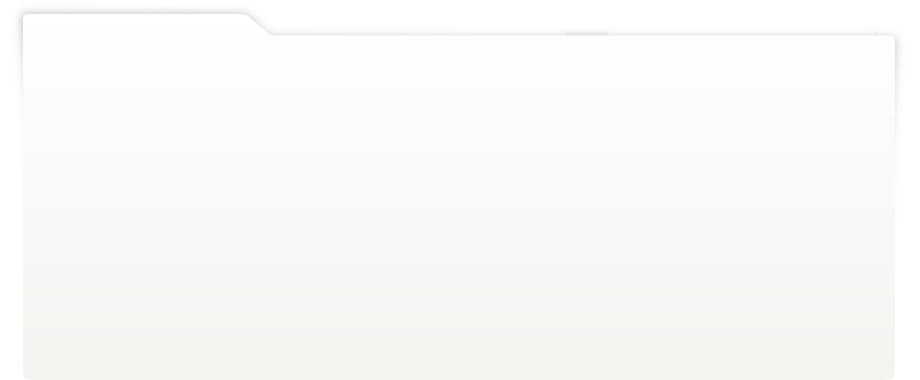
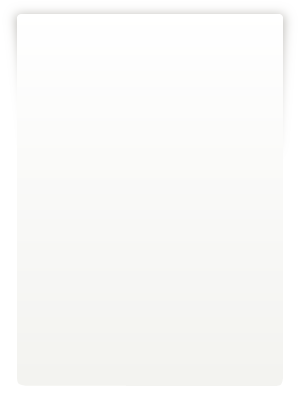
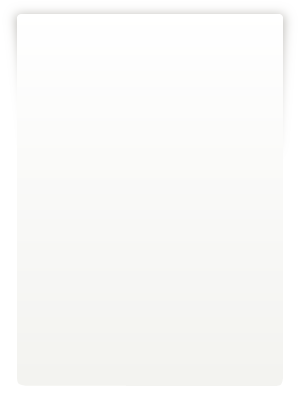
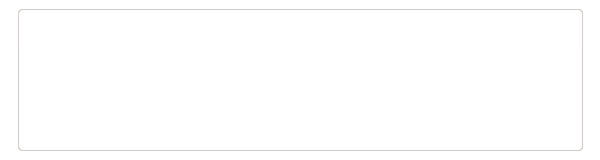
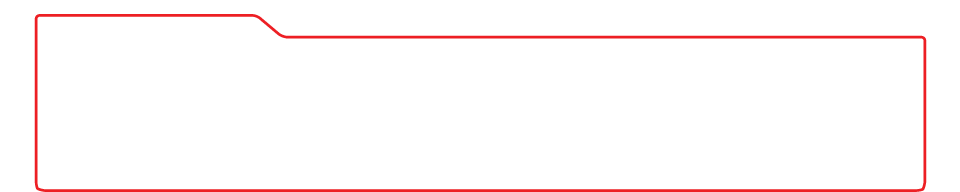
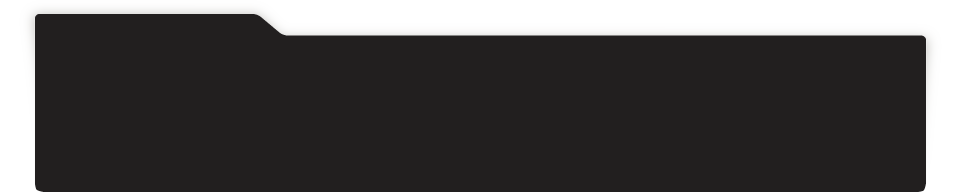
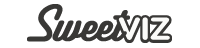
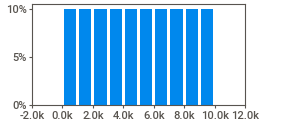
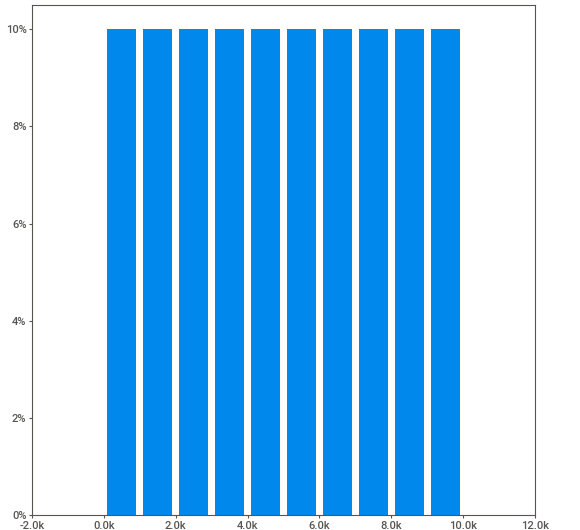
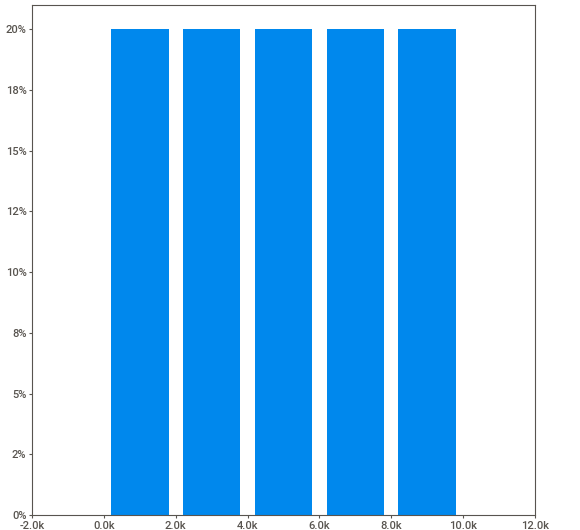
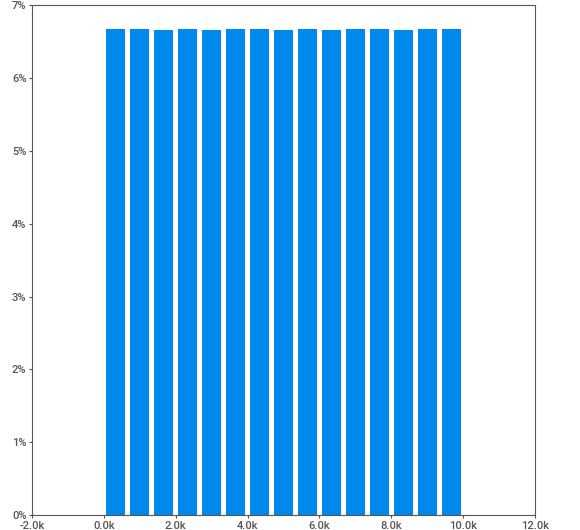
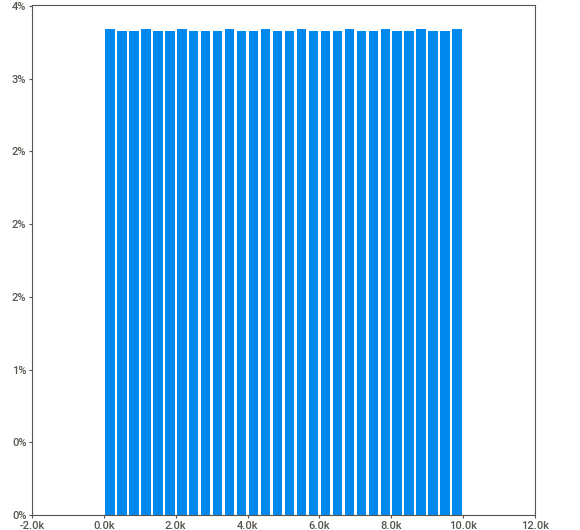
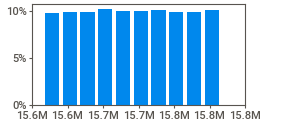
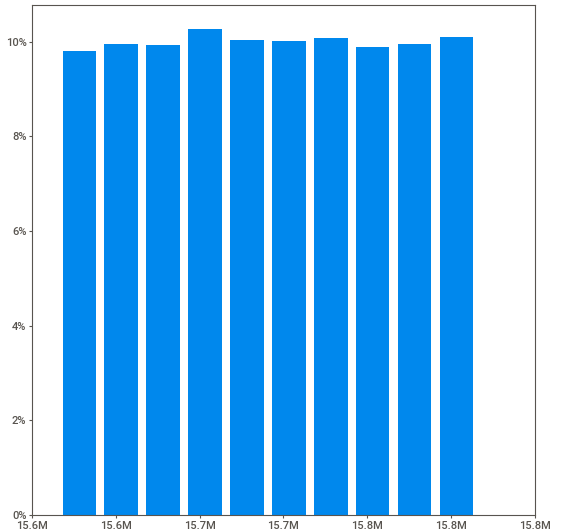
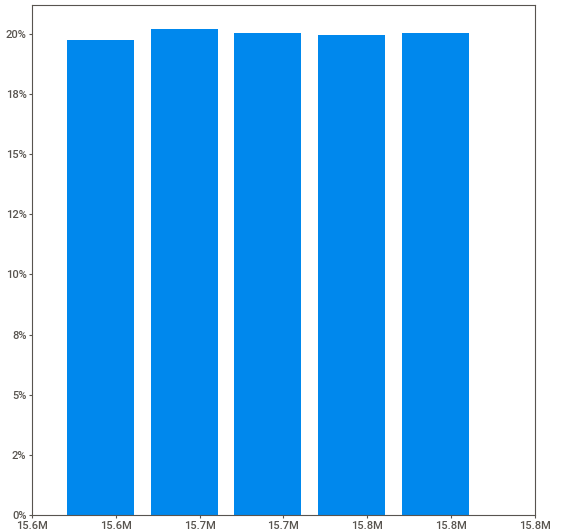
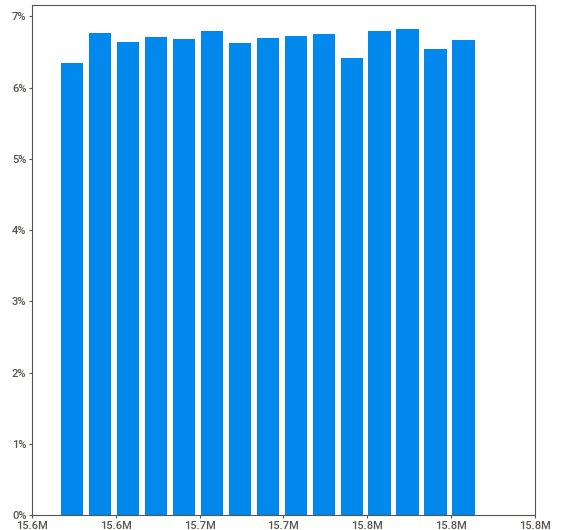
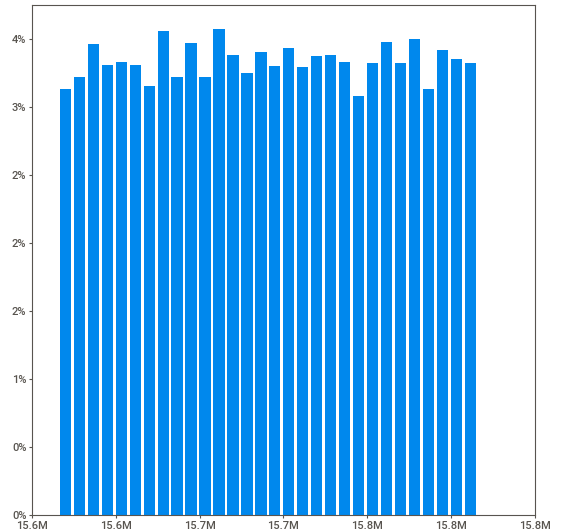
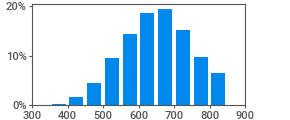
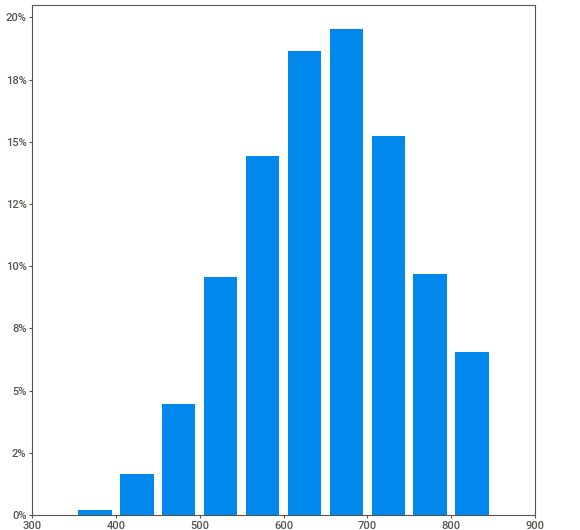
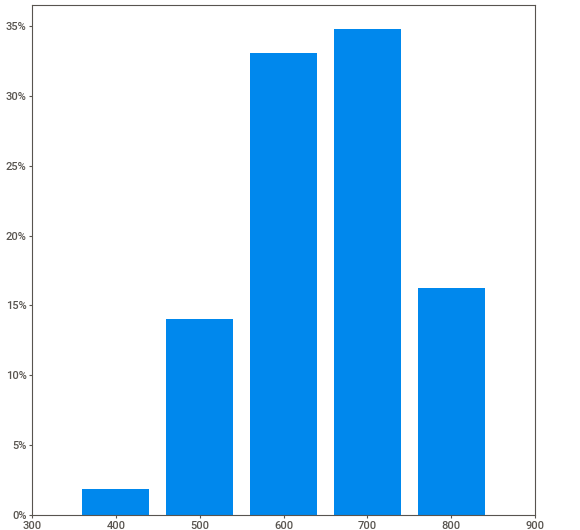
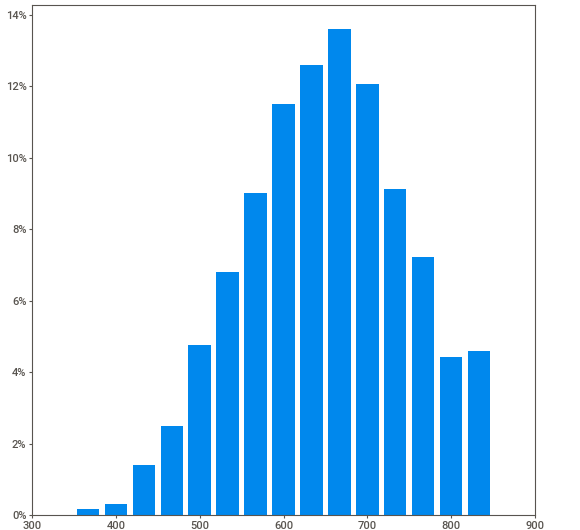
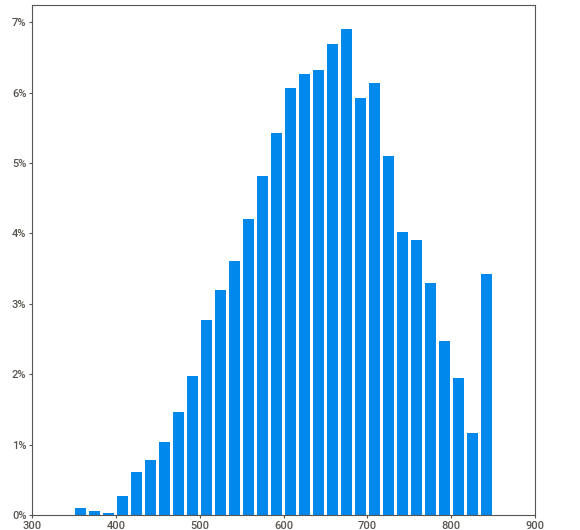
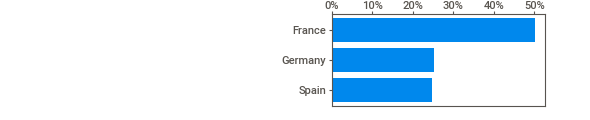
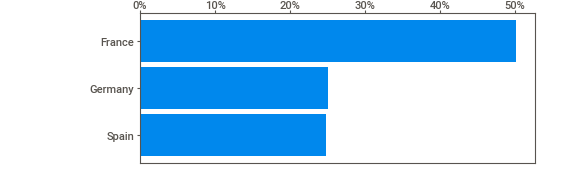
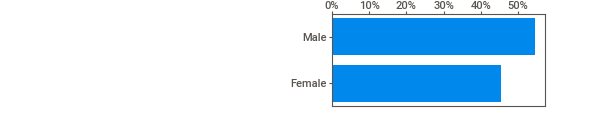
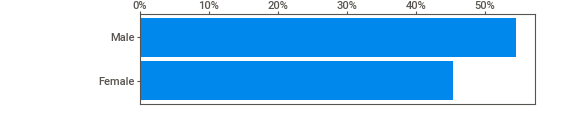
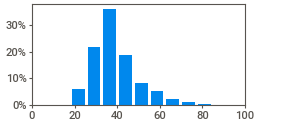
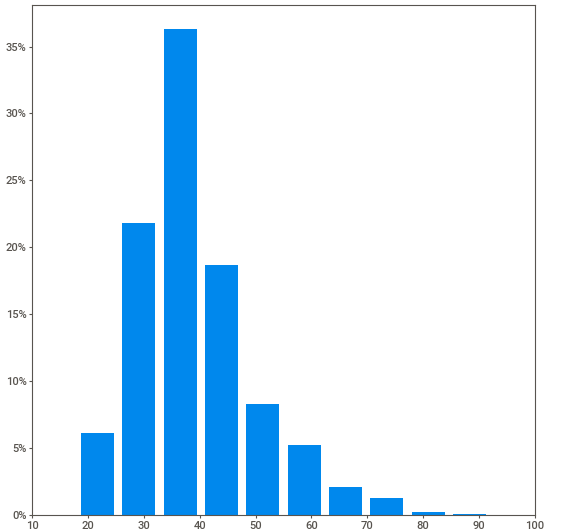
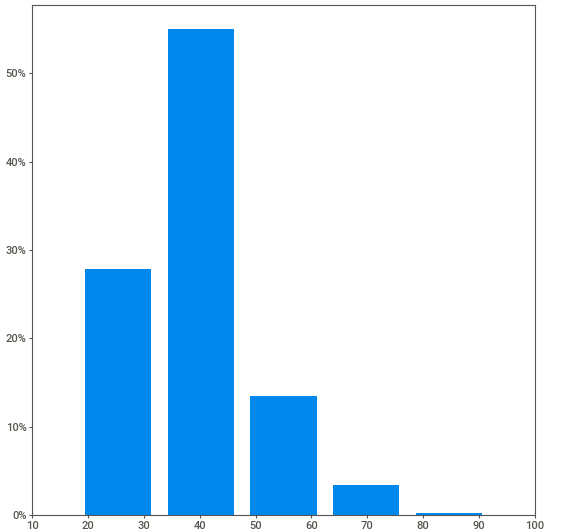
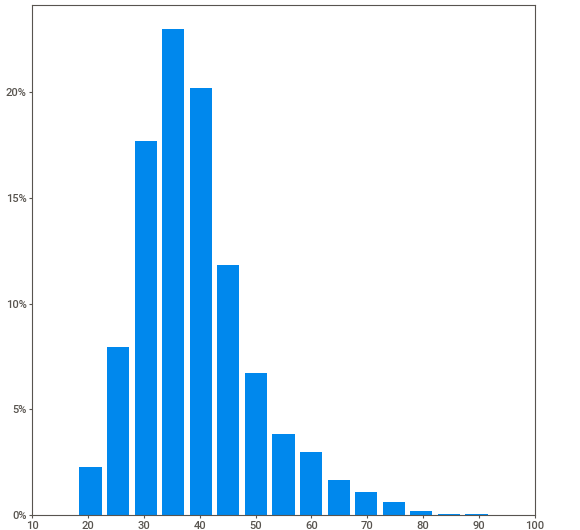
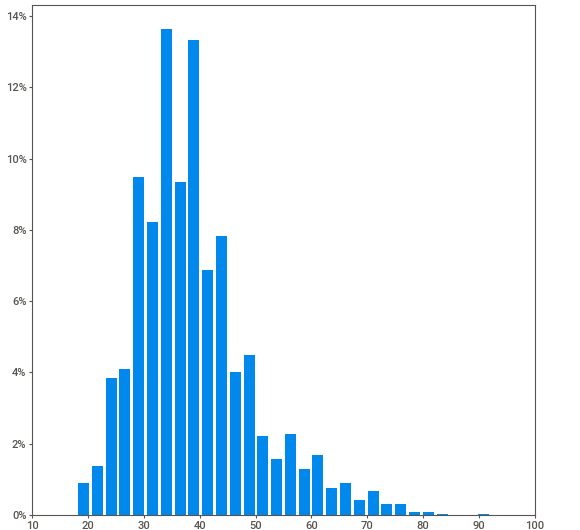
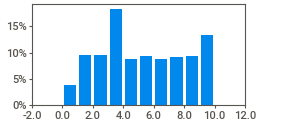
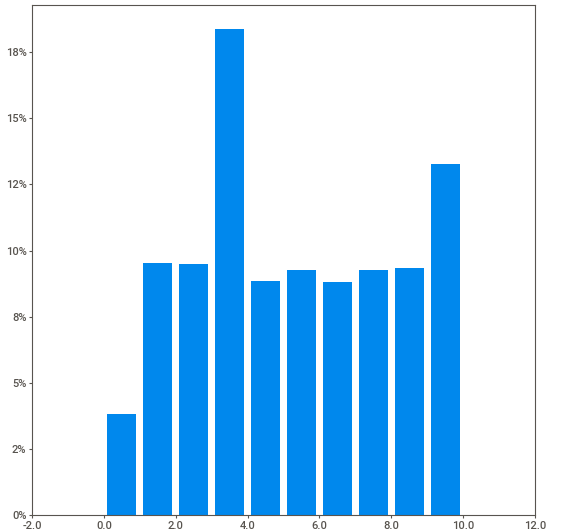
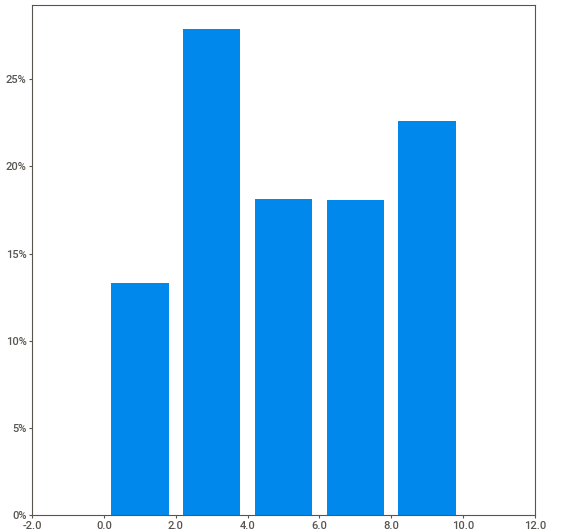
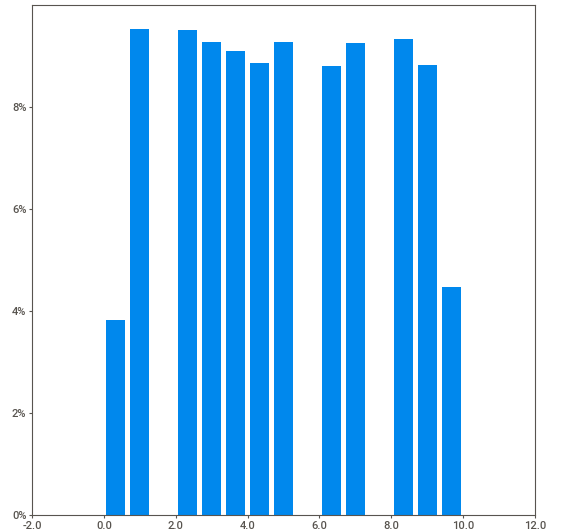
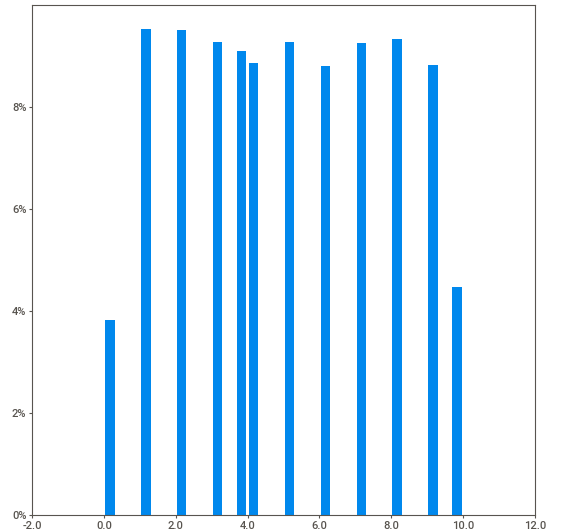
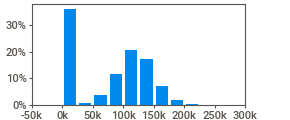
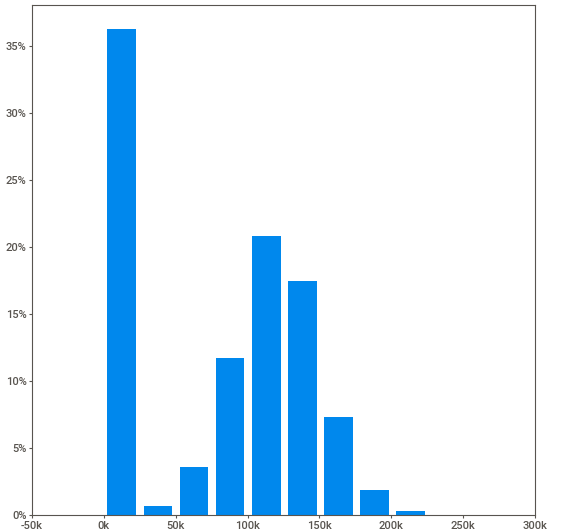
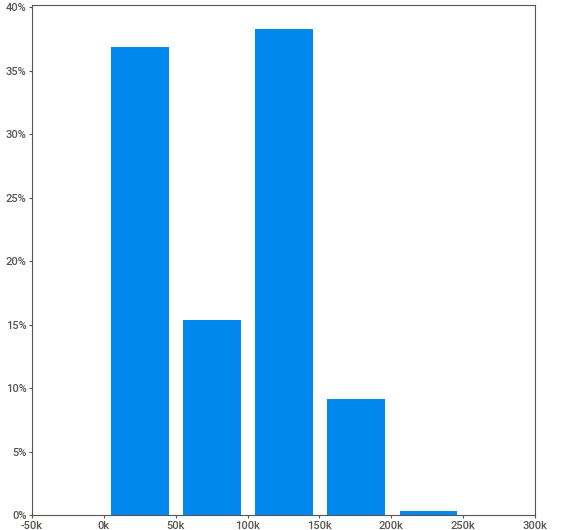
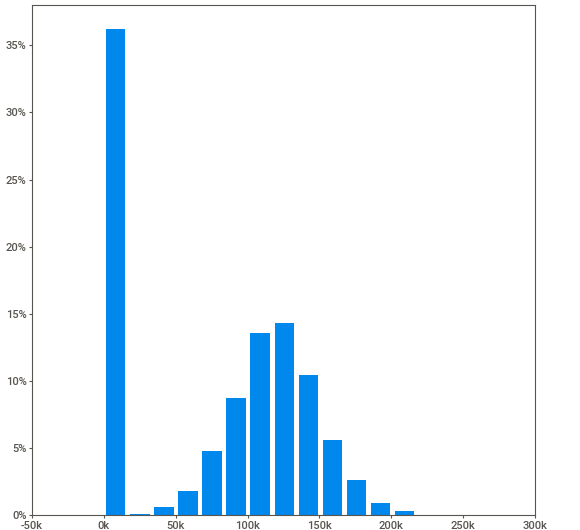
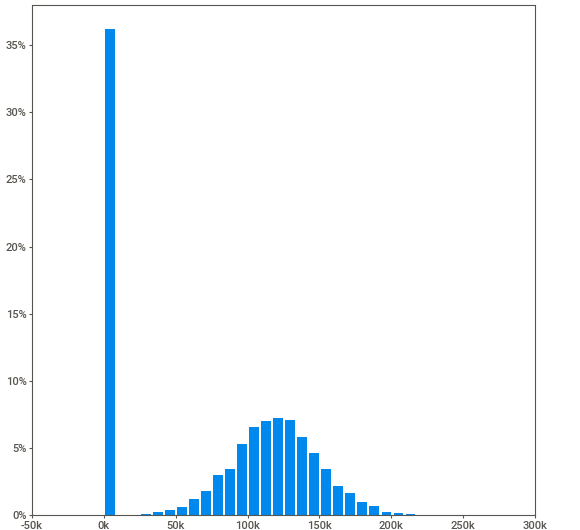
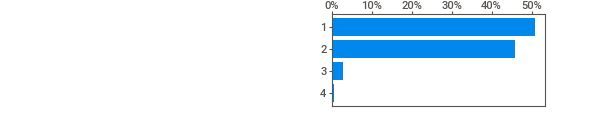
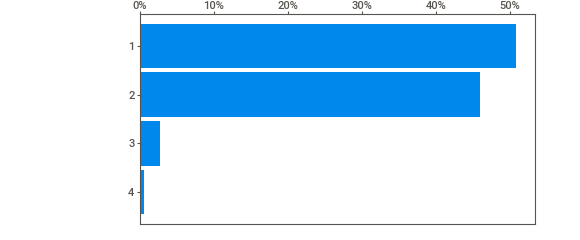
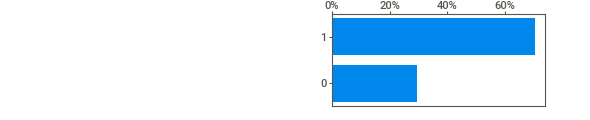
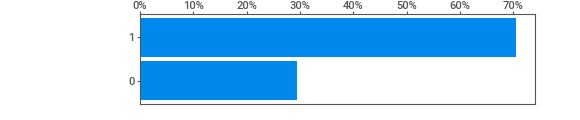
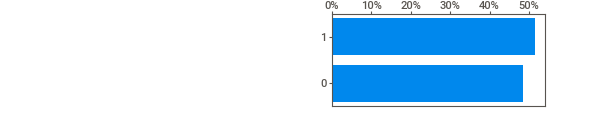
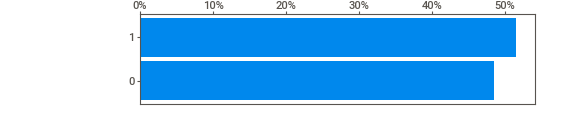
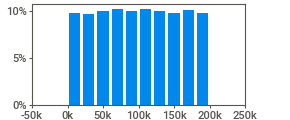
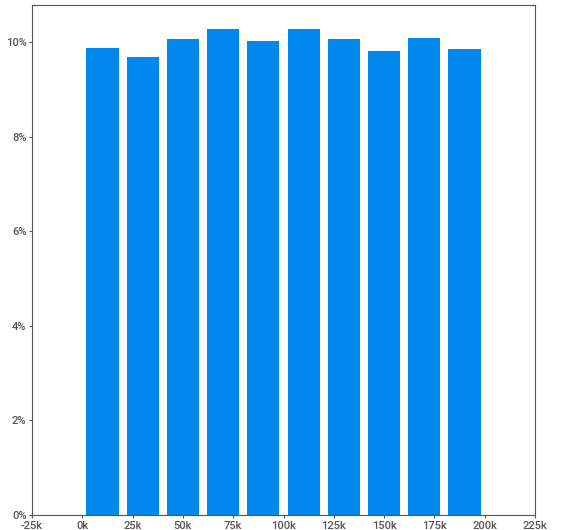
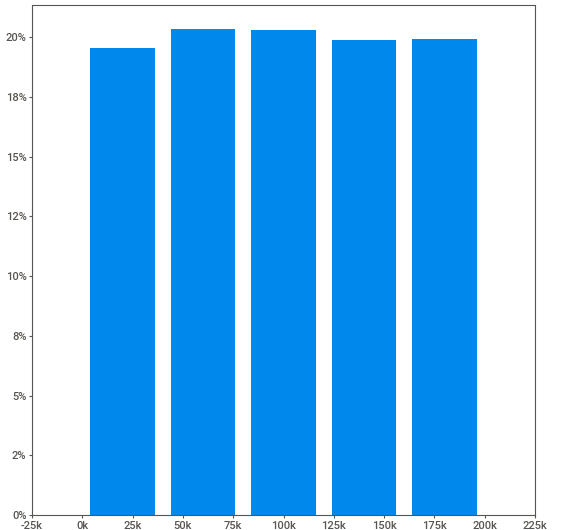
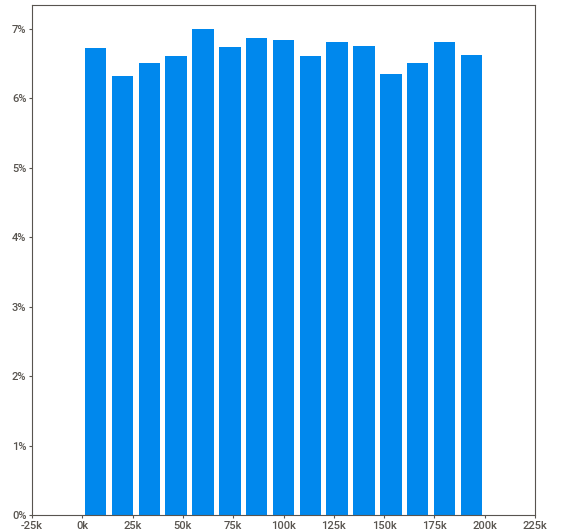
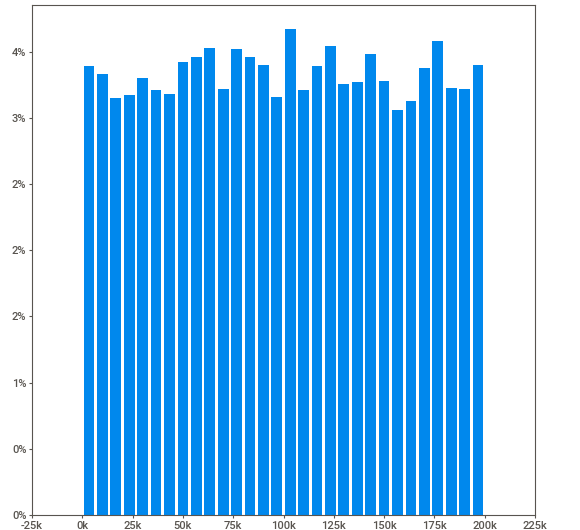
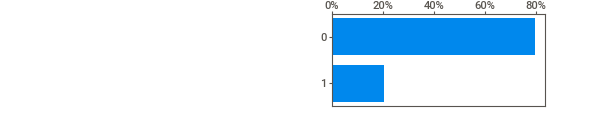
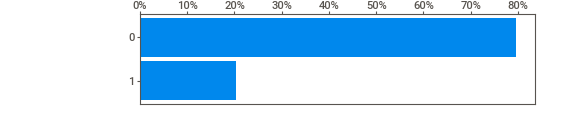
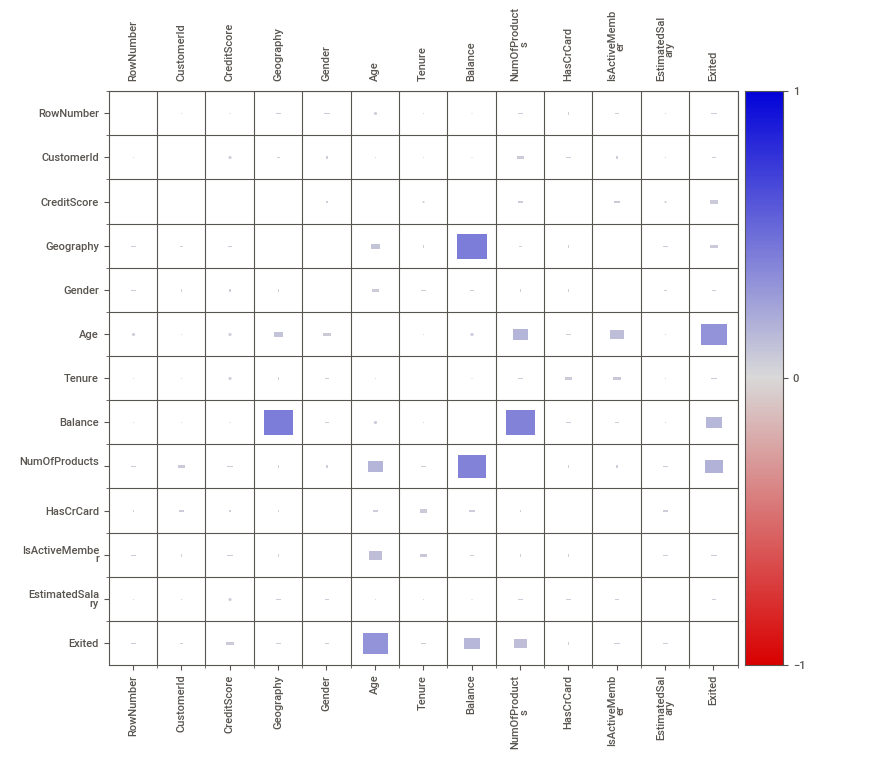
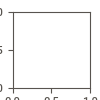

In [10]:
import sweetviz as sv
my_report = sv.analyze(data)
my_report.show_notebook()

## Исследование задачи

Для начала сделаем маштабированные выборки, потом изучим

Нужно сделать дамми-признаки для категориальных столбцов `cats`

In [11]:
data2 = pd.get_dummies(data, columns=cats, drop_first=True)
data2

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,1,15634602,Hargrave,619,42,2.0000,0.00,1,1,101348.88,1,0,0,0,0,0,0
1,2,15647311,Hill,608,41,1.0000,83807.86,0,1,112542.58,0,0,1,0,0,0,0
2,3,15619304,Onio,502,42,8.0000,159660.80,1,0,113931.57,1,0,0,0,0,1,0
3,4,15701354,Boni,699,39,1.0000,0.00,0,0,93826.63,0,0,0,0,1,0,0
4,5,15737888,Mitchell,850,43,2.0000,125510.82,1,1,79084.10,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,39,5.0000,0.00,1,0,96270.64,0,0,0,1,1,0,0
9996,9997,15569892,Johnstone,516,35,10.0000,57369.61,1,1,101699.77,0,0,0,1,0,0,0
9997,9998,15584532,Liu,709,36,7.0000,0.00,0,1,42085.58,1,0,0,0,0,0,0
9998,9999,15682355,Sabbatini,772,42,3.0000,75075.31,1,0,92888.52,1,1,0,1,1,0,0


In [12]:
from sklearn.preprocessing import OneHotEncoder
drop_enc = OneHotEncoder(drop='first').fit(data)
data3 = drop_enc.transform(data)
data3

<10000x39856 sparse matrix of type '<class 'numpy.float64'>'
	with 105571 stored elements in Compressed Sparse Row format>

 `

Теперь выделим из данных параметры и целевой признак, удалим ненужные нам столбцы

In [13]:
features = data2.drop(['Exited','RowNumber', 'CustomerId', 'Surname'], axis=1)
target = data2['Exited']

Разобъем их на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [14]:
features_train, features_tmp, target_train, target_tmp = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_tmp, target_tmp, test_size=0.5, random_state=12345)

Убедимся в правильности

In [15]:
features_train.shape

(6000, 13)

In [16]:
features_train.shape

(6000, 13)

In [17]:
features_test.shape

(2000, 13)

Все хорошо

Для лУчшего обучения модели данные выборок нужно привести к одному масштабу

In [18]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[nums])
features_train[nums] = scaler.transform(features_train[nums])
features_valid[nums] = scaler.transform(features_valid[nums])
features_test[nums] = scaler.transform(features_test[nums])
features_train.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
7479,-0.886751,-0.373192,1.114653,1.232271,1,0,-0.187705,0,1,1,0,0,0
3411,0.608663,-0.183385,1.114653,0.600563,0,0,-0.333945,0,0,0,0,0,0
6027,2.052152,0.480939,-0.688316,1.027098,0,1,1.503095,1,0,1,1,0,0
1247,-1.457915,-1.417129,0.393465,-1.233163,1,0,-1.071061,0,0,1,1,0,0
3716,0.130961,-1.132419,-1.048910,1.140475,0,0,1.524268,1,0,0,0,0,0


Изучим баланс классов

In [19]:
data['Exited'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    79.6%
1    20.4%
Name: Exited, dtype: object

80% значений целевого признака 0, 20% - 1, налицо сильный перевес

**Вывод**
Данные были разбиты на три выборки в соотношении 3:1:1 :
- обучающая
- валидационная
- тестовая

Категориальные столбцы были кодированы техникой OHE

Численные признаки были приведены к одинаковому масштабу

Баланс классов:
0 - 80%

1 - 20%

В данных наблюдается сильный дисбаланс классов, в следующем этапе мы будем его исправлять

## Борьба с дисбалансом

Для удобства проверки метрик сделаем функцию

In [20]:
def test_lr_rf(features_train, target_train, features_valid, target_valid, description):
    model_lr = LogisticRegression(C=1.5, class_weight='balanced', intercept_scaling=1.5,
                                solver='liblinear', random_state=12345)
    
    model_rf = RandomForestClassifier(random_state=12345, criterion='gini', 
                               min_samples_split=5, n_estimators=71)
    
    model_lr.fit(features_train, target_train)
    model_rf.fit(features_train, target_train)
    
    predicted_lr = model_lr.predict(features_valid)
    predicted_rf = model_rf.predict(features_valid)
    
    probabilities_lr = model_lr.predict_proba(features_valid)
    probabilities_one_lr = probabilities_lr[:, 1]
    probabilities_rf = model_rf.predict_proba(features_valid)
    probabilities_one_rf = probabilities_rf[:, 1]
    
    f1_lr = round(f1_score(target_valid, predicted_lr), 3)
    f1_rf = round(f1_score(target_valid, predicted_rf), 3)
    roc_auc_lr = round(roc_auc_score(target_valid, probabilities_one_lr), 3)
    roc_auc_rf = round(roc_auc_score(target_valid, probabilities_one_rf), 3)
    print('metrics', description)
    print('F1 LR:', ' '*4, f1_lr)
    print('F1 RF:', ' '*4, f1_rf)

    print('ROC-AUC LR:', roc_auc_lr)
    print('ROC-AUC RF:', roc_auc_rf)
    print('\n')
    return

для уравновешивания классов воспользуемся апсэмплингом и даунсемплингом, увеличим количество отрицательных целевых признаков

In [21]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [23]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    50.1%
1    49.9%
Name: Exited, dtype: object

In [24]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.28)
target_downsampled.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    52.9%
1    47.1%
Name: Exited, dtype: object

Теперь, когда у нас есть три вида обучающих выборок мы их сравним,  
сначала без балансировки, потом апсемплинг и напоследок даунсемплинг

In [25]:
test_lr_rf(features_train, target_train, features_valid, target_valid, 'not balanced')
test_lr_rf(features_upsampled, target_upsampled, features_valid, target_valid, 'balanced by upsampling')
test_lr_rf(features_downsampled, target_downsampled, features_valid, target_valid, 'balanced by downsampling')

metrics not balanced
F1 LR:      0.559
F1 RF:      0.585
ROC-AUC LR: 0.828
ROC-AUC RF: 0.836


metrics balanced by upsampling
F1 LR:      0.559
F1 RF:      0.593
ROC-AUC LR: 0.828
ROC-AUC RF: 0.839


metrics balanced by downsampling
F1 LR:      0.565
F1 RF:      0.579
ROC-AUC LR: 0.828
ROC-AUC RF: 0.842




В целом, upsampling дал результат лучше по метрике F1, чем downsampling, в то-же время лучше, чем результат без балансировки  
будем использовать его

**Вывод:**

были изучены показания F1-меры для разных моделей в апсемплинге и даунсемплинге

получилось сравнять классы, лучшим показал себя метод апсемплинга

## Изучение моделей

Сделаем функцию для вывода графика AUC-ROC

In [26]:
def auc_roc(target, probabilities_one):
    fpr, tpr, thresholds = roc_curve(target, probabilities_one) 
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-curve')
    plt.show()

    fpr = fpr
    tpr = tpr
    auc_roc = roc_auc_score (target, probabilities_one)
    print("AUC:", auc_roc)
    return auc_roc, fpr, tpr

Попробуем логистическую регрессию

In [ ]:
logistic_regression_hyp = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=12345)

best_model = GridSearchCV(model, logistic_regression_hyp, cv=5,
                           scoring='f1')
best_model.fit(features_upsampled, target_upsampled)
best_model.best_params_

{'C': 1, 'class_weight': 'balanced', 'intercept_scaling': 1.5}

In [27]:
model_log_reg = LogisticRegression(C=1.5, class_weight='balanced', intercept_scaling=1.5,
                                solver='liblinear', random_state=12345
)
model_log_reg.fit(features_upsampled, target_upsampled)
predicted_valid = model_log_reg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5591985428051003


Изучим разные пороговые значения вероятности

In [28]:
probabilities_valid = model_log_reg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0.0, 1.0, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | F1-score = {:.3f}".format(
        threshold, f1))

Threshold = 0.00 | F1-score = 0.346
Threshold = 0.05 | F1-score = 0.356
Threshold = 0.10 | F1-score = 0.376
Threshold = 0.15 | F1-score = 0.400
Threshold = 0.20 | F1-score = 0.434
Threshold = 0.25 | F1-score = 0.460
Threshold = 0.30 | F1-score = 0.485
Threshold = 0.35 | F1-score = 0.511
Threshold = 0.40 | F1-score = 0.534
Threshold = 0.45 | F1-score = 0.558
Threshold = 0.50 | F1-score = 0.559
Threshold = 0.55 | F1-score = 0.571
Threshold = 0.60 | F1-score = 0.568
Threshold = 0.65 | F1-score = 0.572
Threshold = 0.70 | F1-score = 0.553
Threshold = 0.75 | F1-score = 0.538
Threshold = 0.80 | F1-score = 0.498
Threshold = 0.85 | F1-score = 0.445
Threshold = 0.90 | F1-score = 0.325
Threshold = 0.95 | F1-score = 0.212


Лучшую F1 - метрику получил порог 0.65, что не много

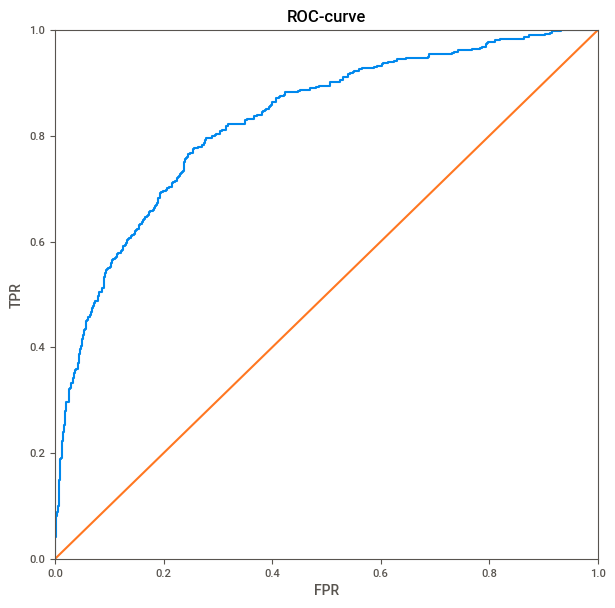

AUC: 0.8279901281764347


In [29]:
auc_roc_lr, fpr_lr, tpr_lr = auc_roc(target_valid, probabilities_one_valid)

Результат не впечатляющий, но хотя бы AUC больше, чем у случайной модели

Попробуем случайный лес

In [ ]:
random_forest_hyp = {'n_estimators': range(3, 30),
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=12345)

grid_search = GridSearchCV(model, random_forest_hyp, cv=5,
                          scoring='f1'
                         )
grid_search.fit(features_upsampled, target_upsampled)
grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 29}

In [30]:
model_rf = RandomForestClassifier(random_state=12345, criterion='entropy', 
                               min_samples_split=5, n_estimators=29
                              )
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6126126126126126


F1 мера уже больше пороговой, оставим эту модель и поработаем над ней

In [ ]:
random_forest_hyp = {'n_estimators': range(30, 80),
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 30)
                    }
model = RandomForestClassifier(random_state=12345)

grid_search = GridSearchCV(model, random_forest_hyp, cv=5,
                           scoring='f1'
                          )
grid_search.fit(features_upsampled, target_upsampled)
grid_search.best_params_

{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 71}

In [31]:
model_rf = RandomForestClassifier(random_state=12345, criterion='gini', 
                               min_samples_split=5, n_estimators=71
                              )
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5927835051546392


In [ ]:
random_forest_hyp = {'n_estimators': range(80, 120),
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 30)
                    }
model = RandomForestClassifier(random_state=12345)

grid_search = GridSearchCV(model, random_forest_hyp, cv=5,
                           scoring='f1'
                          )
grid_search.fit(features_upsampled, target_upsampled)
grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 119}

In [32]:
model_rf = RandomForestClassifier(random_state=12345, criterion='entropy', 
                               min_samples_split=5, n_estimators=119
                              )
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.622107969151671


F1 мера упала, в итоге лучшие гиперпараметры случайного леса:
- `criterion` - `gini`
- `min_samples_split` - `5`
- `n_estimators` - `71`

с ними F1 мера достигла 0.616

найдем подходящий порог истинности

In [33]:
model_rf = RandomForestClassifier(random_state=12345, criterion='gini', 
                               min_samples_split=5, n_estimators=71
                              )
model_rf.fit(features_upsampled, target_upsampled)
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0.0, 1.0, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | F1-score = {:.3f}".format(
        threshold, f1))

Threshold = 0.00 | F1-score = 0.355
Threshold = 0.05 | F1-score = 0.399
Threshold = 0.10 | F1-score = 0.448
Threshold = 0.15 | F1-score = 0.495
Threshold = 0.20 | F1-score = 0.528
Threshold = 0.25 | F1-score = 0.553
Threshold = 0.30 | F1-score = 0.572
Threshold = 0.35 | F1-score = 0.593
Threshold = 0.40 | F1-score = 0.602
Threshold = 0.45 | F1-score = 0.610
Threshold = 0.50 | F1-score = 0.593
Threshold = 0.55 | F1-score = 0.589
Threshold = 0.60 | F1-score = 0.583
Threshold = 0.65 | F1-score = 0.552
Threshold = 0.70 | F1-score = 0.517
Threshold = 0.75 | F1-score = 0.482
Threshold = 0.80 | F1-score = 0.427
Threshold = 0.85 | F1-score = 0.333
Threshold = 0.90 | F1-score = 0.231
Threshold = 0.95 | F1-score = 0.083


Манипуляции с порогом нам ничего не дали, это связано с тем, что мы уравняли баланс классов

Взглянем на матрицу ошибок

[[1454  128]
 [ 188  230]]


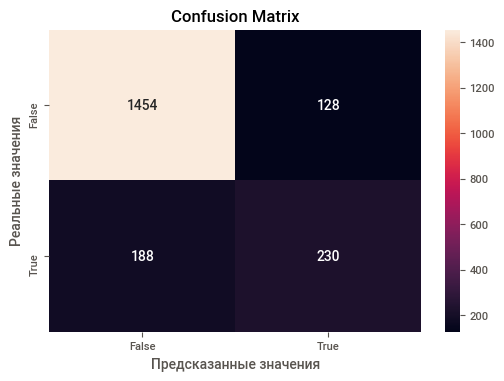

In [34]:
y_pred = model_rf.predict(features_valid)
cm = confusion_matrix(target_valid, y_pred)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Предсказанные значения');ax.set_ylabel('Реальные значения'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['False', 'True']);

Ошибки конечно же есть, число TN большое, ммодель лучше предсказывает то, что клиент не уйдет, FP меньше, чем FN, это вызвано большим дмзбалансом классов, модель недообучилась, но с этим уже вряд ли можно разобраться, все таки входных данных мало для уверенной модели

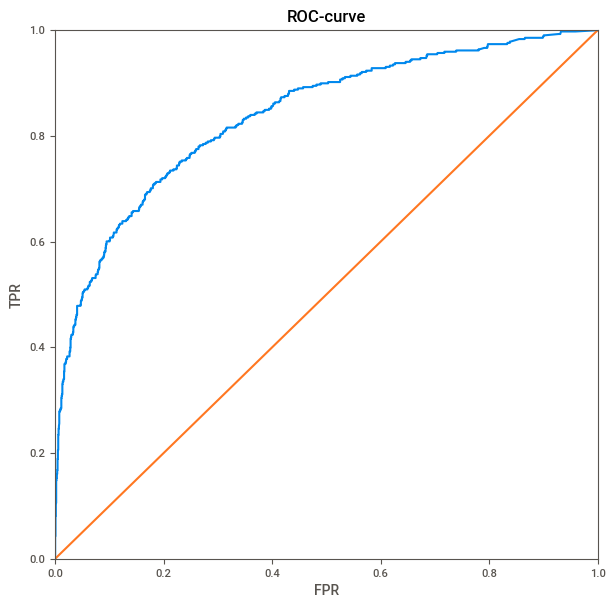

AUC: 0.8390467822815284


In [35]:
auc_roc_rf, fpr_rf, tpr_rf = auc_roc(target_valid, probabilities_one_valid)

Сравним графики ROC бок о бок

<Figure size 600x400 with 0 Axes>

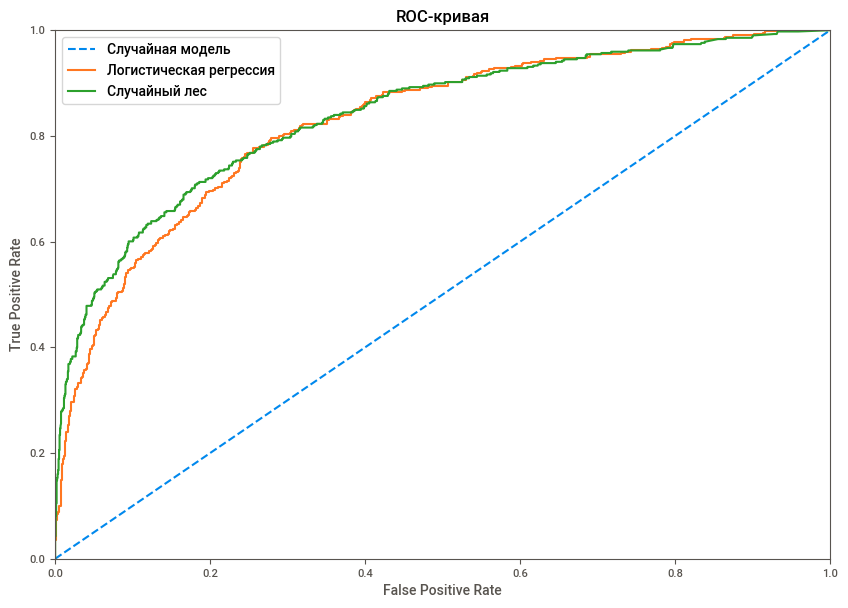

AUC LR: 0.8279901281764347
AUC RF: 0.8390467822815284


In [36]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_lr,tpr_lr)
plt.plot(fpr_rf,tpr_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Логистическая регрессия','Случайный лес'),
           loc= 'upper left') 
plt.show()
print('AUC LR:', auc_roc_lr)
print('AUC RF:', auc_roc_rf)

F1-LR 0.572

F1-RF 0.616
 

По сравнению с линейной регрессией, случайный лес показывает сильно большую F1 - меру, это значит, что предсказания точнее, по графику ROC видно, что лучшее пороговое значение около 0.5, что мы уже узнали

**Вывод:**
были изучены две модели:
- Логистическая регрессия
- Случайный лес

для каждой из них были найдены оптимальные гиперпараметры, рассчитаны метрики

Были изучены графики ROC, было сравнение AUC-ROC метрик моделей


Из них лучшая для нашей задачи - Случайный лес

ее F1-мера на тестовой выборке 0.594
Ее гиперпараметры:
- `criterion` - `gini`
- `min_samples_split` - `5`
- `n_estimators` - `71`

Протестируем эту модель на тестовой выборке

## Тестирование модели

F1: 0.5994832041343668


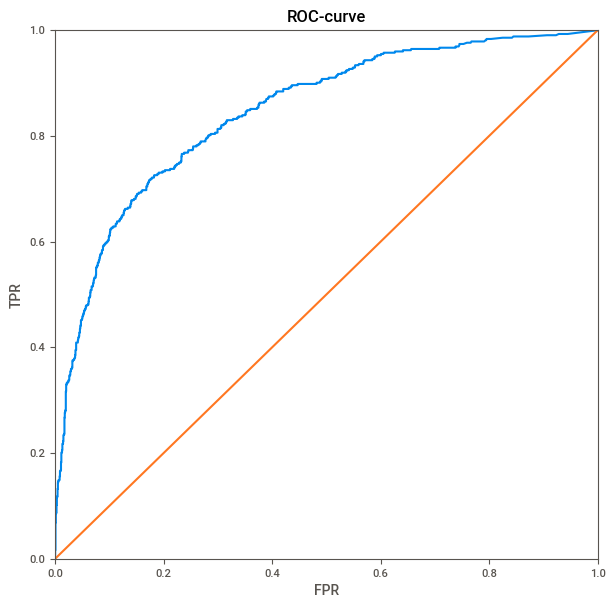

AUC: 0.8455869015442133


In [37]:
model_rf = RandomForestClassifier(random_state=12345, criterion='gini', 
                               min_samples_split=5, n_estimators=70
                              )

model_rf.fit(features_upsampled, target_upsampled)
predicted_test = model_rf.predict(features_test)
probabilities_test = model_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print("F1:", f1_score(target_test, predicted_test))
_, _, _ = auc_roc(target_test, probabilities_one_test)


На тестовой выборке F1 мера упала, это вызвано неоднородностью данных и их небольшим количеством, но тем не менее нам такой результат подходит

Изучим важность признаков получившейся модели

CreditScore          0.128034
Age                  0.243403
Tenure               0.081397
Balance              0.139621
HasCrCard            0.017861
IsActiveMember       0.041337
EstimatedSalary      0.127003
Geography_Germany    0.036234
Geography_Spain      0.012600
Gender_Male          0.023909
NumOfProducts_2      0.105149
NumOfProducts_3      0.034782
NumOfProducts_4      0.008671
dtype: float64


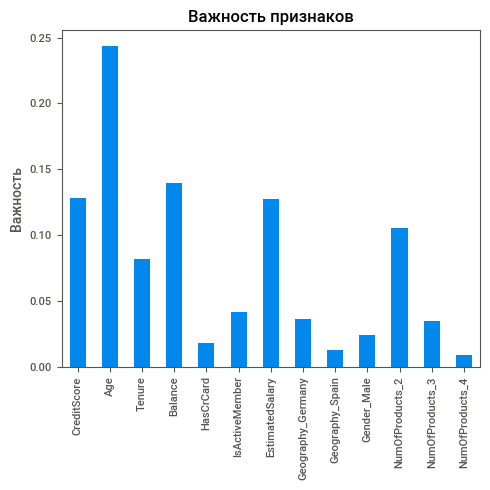

In [38]:
importances = pd.Series(model_rf.feature_importances_,
                         features_test.columns)
print(importances)
fig, ax = plt.subplots(figsize=(5,5))
importances.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Видим, что самым важным признаком является возраст, важность остальных видно на графике

**Вывод:**  
Была протестирована наилучшая модель, ее метрики составили:  
F1 - 0.61  
AUC - 0.85  

были изучены важности признаков



# Общий вывод

Цель исследования:
- Построить модель, прогнозирующую уйдёт клиент из банка в ближайшее время или нет
- Значение F1-меры должно быть больше 0.59

Этапы работы:

**1)** Подготовка данных:

    был импортирован датасет, изучен, заполнены пропуски
**2)** Исследование задачи:
    
    Данные были разбиты на три выборки в соотношении 3:1:1
    Категориальные столбцы были кодированы техникой OHE
    Численные признаки были приведены к одинаковому масштабу
    Был исследован и выявлен дисбаланс классов

**3)** Борьба с дисбалансом
    
    были изучены показания F1-меры для разных моделей в апсемплинге и даунсемплинге
    получилось сравнять классы, лучшим показал себя метод апсемплинга

**4)** Изучение моделей
    
    были изучены и обучены две модели:
    - Логистическая регрессия
    - Случайный лес
    для каждой из них были найдены оптимальные гиперпараметры, рассчитаны метрики
    Были изучены графики ROC, было сравнение AUC-ROC метрик моделей
    Из них лучшая для нашей задачи - Случайный лес
    ее F1-мера на тестовой выборке 0.61

**5)** Тестирование модели
    
    Была протестирована наилучшая модель, ее метрики составили:
    F1 - 0.61
    AUC - 0.85
    
    были изучены важности признаков, самый важный признак - возраст клиента
    
    
    
    
Обе цели были достигнуты


Рекомендации бизнесу:
- используя прогнозы об уходе клиента можно сделать им специальные предложения, например, повышенный кешбек